In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
from data_processing import *
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import optuna

In [2]:
### Load data
data_dir = "../01_Datenaufbereitung/Output/Calculated/"
all_data = load_data(data_dir)


Found 15 parquet files


Processing cells:   0%|          | 0/15 [00:00<?, ?cell/s]

Processing C01 ...


Processing cells:   7%|▋         | 1/15 [00:20<04:50, 20.73s/cell]

Processing C03 ...


Processing cells:  13%|█▎        | 2/15 [00:30<03:04, 14.19s/cell]

Processing C05 ...


Processing cells:  20%|██        | 3/15 [00:38<02:15, 11.32s/cell]

Processing C07 ...


Processing cells:  27%|██▋       | 4/15 [00:46<01:49,  9.91s/cell]

Processing C09 ...


Processing cells:  33%|███▎      | 5/15 [00:50<01:18,  7.84s/cell]

Processing C11 ...


Processing cells:  40%|████      | 6/15 [00:54<01:01,  6.80s/cell]

Processing C13 ...


Processing cells:  47%|████▋     | 7/15 [00:56<00:41,  5.20s/cell]

Processing C15 ...


Processing cells:  53%|█████▎    | 8/15 [00:59<00:30,  4.30s/cell]

Processing C17 ...


Processing cells:  60%|██████    | 9/15 [01:06<00:32,  5.36s/cell]

Processing C19 ...


Processing cells:  67%|██████▋   | 10/15 [01:14<00:30,  6.13s/cell]

Processing C21 ...


Processing cells:  73%|███████▎  | 11/15 [01:22<00:26,  6.71s/cell]

Processing C23 ...


Processing cells:  80%|████████  | 12/15 [01:30<00:21,  7.08s/cell]

Processing C25 ...


Processing cells:  87%|████████▋ | 13/15 [01:36<00:13,  6.66s/cell]

Processing C27 ...


Processing cells:  93%|█████████▎| 14/15 [01:43<00:06,  6.82s/cell]

Processing C29 ...


Processing cells: 100%|██████████| 15/15 [01:48<00:00,  7.24s/cell]


In [3]:
train_df, val_df, test_df = split_data(all_data, train=13, val=1, test=1,parts = 5)
train_scaled, val_scaled, test_scaled = scale_data(train_df, val_df, test_df)

Cell split completed:
Training set: 13 cells
Validation set: 1 cells
Test set: 1 cells
Final dataset sizes:
Training set: 48609 rows (split into 65 parts)
Validation set: 4561 rows from 1 cells
Test set: 4602 rows from 1 cells


In [18]:
test_scaled

,Testtime[h],Current[A],Voltage[V],Temperature[°C],cell_id,SOH_ZHU
32481,0,2.174990,3.341500,0.226865,C19,0.999990
32482,1,-1.893207,-1.310356,-0.009811,C19,0.999990
32483,2,-0.130288,-0.665709,-0.455282,C19,0.999990
32484,3,-0.084899,-0.625828,-0.461772,C19,0.999990
32485,4,-0.072331,-0.635056,-0.460911,C19,0.999990
...,...,...,...,...,...,...
37078,4597,-0.315492,-0.496652,-0.298920,C19,0.839529
37079,4598,-0.328447,-0.900255,-0.318356,C19,0.839529
37080,4599,-0.572344,-1.160269,-0.293186,C19,0.839529
37081,4600,-0.176560,-0.956523,-0.314913,C19,0.839529


In [5]:
### Visualize data
# visualize_data(all_data)
# inspect_data_ranges(all_data)
# inspect_data_ranges(train_scaled)
# plot_dataset_soh(train_df, "Train")
# plot_dataset_soh(val_df, "Validation")
# plot_dataset_soh(test_df, "Test")

In [6]:
class SequenceDataset(Dataset):
    def __init__(self, df, seed_len=36, pred_len=5,
                 feature_cols=["Current[A]", "Voltage[V]", "Temperature[°C]"],
                 target_col="SOH_ZHU"):
        self.seed_len = seed_len
        self.pred_len = pred_len
        self.features = df[feature_cols].values
        self.targets = df[target_col].values

    def __len__(self):
        return len(self.features) - (self.seed_len + self.pred_len) + 1

    def __getitem__(self, idx):
        # X: 前 seed_len 个时间步 (batch_size, seed_len, num_features)
        x_seq = self.features[idx : idx + self.seed_len]
        # Y: 后续 pred_len 个目标 (batch_size, pred_len)
        y_seq = self.targets[idx + self.seed_len : idx + self.seed_len + self.pred_len]
        
        x = torch.tensor(x_seq, dtype=torch.float32)
        y = torch.tensor(y_seq, dtype=torch.float32)
        return x, y


# Using ground truth of SOH and 3 covariances
seq_len=36
batch_size=16
train_cols = ["SOH_ZHU","Current[A]", "Voltage[V]", "Temperature[°C]"]
# feature_cols=["Current[A]", "Voltage[V]", "Temperature[°C]"]
# train_cols = ["Current[A]", "Voltage[V]", "Temperature[°C]", "Q_sum", "EFC", 'InternalResistance[Ohms]']
# feature_cols=["SOH_ZHU", "Current[A]", "Voltage[V]", "Temperature[°C]", "Q_sum", "EFC", 'InternalResistance[Ohms]']

train_dataset = SequenceDataset(train_scaled, feature_cols=train_cols)
val_dataset = SequenceDataset(val_scaled, feature_cols=train_cols)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)




In [8]:
class LSTMAttention(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, num_layers: int, dropout: float):
        super(LSTMAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout= dropout)
        # Attention layer: project hidden state at each time step to a scalar attention weight
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, dtype=x.dtype, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, dtype=x.dtype, device=x.device)
        lstm_out, _ = self.lstm(x,(h0,c0))  # lstm_out shape: (batch_size, seq_len, hidden_dim)
        
        # # Compute attention scores and normalize them
        attn_scores = self.attention(lstm_out)  # shape: (batch_size, seq_len, 1)
        attn_weights = torch.softmax(attn_scores, dim=1)  # softmax over seq_len
        
        # # Compute the context vector as the weighted sum of LSTM outputs
        context = torch.sum(attn_weights * lstm_out, dim=1)  # shape: (batch_size, hidden_dim)
        out = self.fc(context )  # Final prediction, shape: (batch_size, 1)
        return out.squeeze(-1)

In [24]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import copy

def train_model(
    model, 
    criterion, 
    optimizer, 
    train_loader, 
    val_loader, 
    num_epochs=10, 
    patience=5
):
    """
    纯自回归多步预测训练:
      - 不使用 Teacher Forcing。 
      - 训练与验证都采用与测试时相同的滚动预测逻辑 (每步都用模型预测值当作下一步输入)。
      
    适用于单步输出模型(如 model(current_seq) -> (batch_size,))，需要多次迭代获得多步预测。
    
    输入数据假设:
      X_batch: (batch_size, seed_len, num_features)
      Y_batch: (batch_size, pred_len)
    模型输出:
      当输入 (batch_size, seed_len, num_features) 时, 返回 (batch_size,) — 单步预测值。
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_mae': [],
        'val_rmse': [],
        'val_r2': []
    }
    
    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0
    
    # 目标列在 features 中的位置, 根据你的数据做相应调整; 这里默认是 0
    target_idx = 0
    
    for epoch in range(num_epochs):
        # -----------------------------
        # 1) Training Loop (pure autoregressive)
        # -----------------------------
        model.train()
        train_losses = []
        
        for X_batch, Y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=False):
            X_batch = X_batch.to(device)  # shape: (batch_size, seed_len, num_features)
            Y_batch = Y_batch.to(device)  # shape: (batch_size, pred_len)
            
            batch_size, seed_len, num_features = X_batch.shape
            pred_len = Y_batch.shape[1]
            
            # current_seq 作为自回归滚动窗口
            current_seq = X_batch.clone()  # (batch_size, seed_len, num_features)
            preds_steps = []
            
            for t in range(pred_len):
                # 1) 用当前序列预测下一个时间步
                pred = model(current_seq)  # (batch_size,)
                preds_steps.append(pred.unsqueeze(1))  # -> (batch_size, 1)
                
                # 2) 将 pred 写回 current_seq 的目标列, 准备下一个时间步
                #   - 如果还有下一个时刻的其他特征, 就用 X_batch 中的真实值做替换
                #   - 否则就保持最后一帧特征不变
                if seed_len + t < X_batch.shape[1]:
                    # 说明 X_batch 还提供了这个时刻的其它特征
                    next_input = X_batch[:, seed_len + t, :].clone()
                else:
                    # 超过了 seed_len 或无更多特征, 只能保持当前最后一帧
                    next_input = current_seq[:, -1, :].clone()
                
                # 将目标列替换为模型预测
                next_input[:, target_idx] = pred
                
                # 3) 移动窗口: 去掉最前面一帧, 拼上新预测帧
                #   current_seq[:, 1:, :] -> 舍弃最前的 1 步
                #   next_input.unsqueeze(1) -> (batch_size, 1, num_features)
                current_seq = torch.cat([current_seq[:, 1:, :], next_input.unsqueeze(1)], dim=1)
            
            # 拼接所有预测, (batch_size, pred_len)
            preds_steps = torch.cat(preds_steps, dim=1)
            
            # 计算多步预测的loss
            loss = criterion(preds_steps, Y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
        
        mean_train_loss = np.mean(train_losses)
        history['train_loss'].append(mean_train_loss)
        
        # -----------------------------
        # 2) Validation Loop (pure autoregressive)
        # -----------------------------
        model.eval()
        val_losses = []
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for X_val, Y_val in val_loader:
                X_val = X_val.to(device)
                Y_val = Y_val.to(device)
                batch_size, seed_len, num_features = X_val.shape
                pred_len = Y_val.shape[1]
                
                current_seq = X_val.clone()
                preds_steps = []
                
                for t in range(pred_len):
                    # 与训练相同的滚动预测方式
                    pred = model(current_seq)  # (batch_size,)
                    preds_steps.append(pred.unsqueeze(1))
                    
                    if seed_len + t < X_val.shape[1]:
                        next_input = X_val[:, seed_len + t, :].clone()
                    else:
                        next_input = current_seq[:, -1, :].clone()
                    
                    next_input[:, target_idx] = pred
                    current_seq = torch.cat([current_seq[:, 1:, :], next_input.unsqueeze(1)], dim=1)
                
                preds_steps = torch.cat(preds_steps, dim=1)  # (batch_size, pred_len)
                val_loss = criterion(preds_steps, Y_val)
                val_losses.append(val_loss.item())
                
                all_preds.append(preds_steps.cpu().numpy())
                all_targets.append(Y_val.cpu().numpy())
        
        mean_val_loss = np.mean(val_losses)
        history['val_loss'].append(mean_val_loss)
        
        # 计算整体 MAE, RMSE, R2
        all_preds = np.concatenate(all_preds, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)
        mae = np.mean(np.abs(all_preds - all_targets))
        rmse = np.sqrt(np.mean((all_preds - all_targets)**2))
        
        ss_res = np.sum((all_targets - all_preds)**2)
        ss_tot = np.sum((all_targets - np.mean(all_targets))**2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 1e-12 else 0.0
        
        history['val_mae'].append(mae)
        history['val_rmse'].append(rmse)
        history['val_r2'].append(r2)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {mean_train_loss:.4e} | Val Loss: {mean_val_loss:.4e} | "
              f"MAE: {mae:.4e} | RMSE: {rmse:.4e} | R2: {r2:.4f}")
        
        # -----------------------------
        # 3) Early Stopping
        # -----------------------------
        if mean_val_loss < best_val_loss:
            best_val_loss = mean_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1} because validation loss did not improve.")
                break
    
    return history, best_model_state


In [25]:
model = LSTMAttention(input_dim=4, hidden_dim=128, num_layers=3, dropout= 0.3)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.MSELoss()
history, best_state = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5, patience=10)
torch.save(best_state, "best_model.pth")

Epoch [1/5] | Train Loss: 1.3557e-02 | Val Loss: 5.6418e-04 | MAE: 2.3261e-02 | RMSE: 2.3753e-02 | R2: 0.7287


Epoch [2/5] | Train Loss: 4.7019e-04 | Val Loss: 2.0313e-05 | MAE: 2.8706e-03 | RMSE: 4.5070e-03 | R2: 0.9902


Epoch [3/5] | Train Loss: 4.3186e-04 | Val Loss: 2.1863e-05 | MAE: 3.0289e-03 | RMSE: 4.6758e-03 | R2: 0.9895


Epoch [4/5] | Train Loss: 3.9507e-04 | Val Loss: 2.1648e-05 | MAE: 3.0458e-03 | RMSE: 4.6528e-03 | R2: 0.9896


Epoch [5/5] | Train Loss: 3.7905e-04 | Val Loss: 3.8688e-04 | MAE: 1.9047e-02 | RMSE: 1.9669e-02 | R2: 0.8140


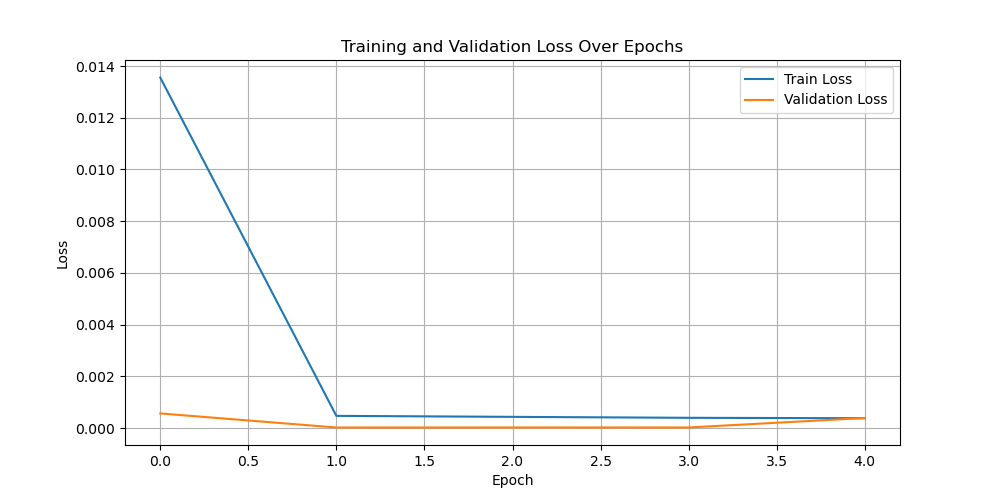

In [26]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

# # Example usage:
# # Assume LSTMAttentionModel, train_loader, and val_loader have been defined elsewhere.
# def objective(trial):
#     # Suggest hyperparameters
#     hidden_size = trial.suggest_int('hidden_size', 10, 100)
#     num_layers = trial.suggest_int('num_layers', 1, 5)
#     learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)

#     # Instantiate model with suggested hyperparameters
#     model = LSTMAttention(input_dim=6, hidden_dim=hidden_size, num_layers=num_layers).type(torch.float32).to(device)

#     # Define your loss function and optimizer with suggested hyperparameters
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#     # Call your train and validate function
#     history, best_state = train_model(model, criterion, optimizer, train_loader, val_loader)

#     # Extract last validation loss
#     last_val_loss = history['val_loss'][-1]
#     return last_val_loss

#     # Optuna study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=10)

# # Extract best trial
# best_trial = study.best_trial
# print(f"Best trial: {best_trial}")

# best_hyperparams = study.best_trial.params
# print('Best hyperparameters:', best_hyperparams)

In [27]:
def predict_autoregressive(model, df, seq_len=36,
                           input_cols=["SOH_ZHU", "Current[A]", "Voltage[V]", "Temperature[°C]"],
                           target_col="SOH_ZHU",
                           device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    """
    Autoregressive prediction: Instead of using the true SOH for the next step,
    use the model's last predicted SOH.
    
    Procedure:
      - Copy the specified input columns into an array.
      - Use the first `seq_len` true values as the initial sequence.
      - From index seq_len onward, update the target column with the model's prediction for subsequent predictions.
    
    Parameters:
      model: Trained PyTorch model.
      df (pd.DataFrame): DataFrame containing the data.
      seq_len (int): Sequence length.
      input_cols (list): List of columns used for autoregressive prediction, which must include the target column (e.g., "SOH_ZHU").
      target_col (str): Name of the target column, default "SOH_ZHU".
      device: Device to use (CPU or GPU).
    
    Returns:
      preds (np.ndarray): An array of predictions with the same length as df (the first seq_len values are NaN).
    """
    model.eval()
    # Copy the data for the specified input columns, ensuring the original df is not modified
    data_array = df[input_cols].values.copy()
    preds = np.full(len(data_array), np.nan)
    
    # Find the index of the target column within input_cols
    target_idx = input_cols.index(target_col)
    
    # Save the true target values (for metric calculations)
    y_true = df[target_col].values.copy()
    
    with torch.no_grad():
        # Loop over the data such that we have a full sequence of length seq_len
        for i in range(seq_len, len(data_array)):
            # Prepare the input sequence of shape (seq_len, num_features)
            input_seq = data_array[i - seq_len: i]
            x_t = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
            
            # Get the predicted SOH value from the model
            pred_soh = model(x_t).item()
            preds[i] = pred_soh
            
            # Write the predicted value back to data_array at the target column, to be used for future predictions
            data_array[i, target_idx] = pred_soh

    # Filter out the first seq_len values (which are NaN) for metric calculations
    valid_mask = ~np.isnan(preds)
    y_pred_valid = preds[valid_mask]
    y_true_valid = y_true[valid_mask]

    mae = np.mean(np.abs(y_pred_valid - y_true_valid))
    rmse = np.sqrt(np.mean((y_pred_valid - y_true_valid)**2))
    
    ss_res = np.sum((y_true_valid - y_pred_valid)**2)
    ss_tot = np.sum((y_true_valid - np.mean(y_true_valid))**2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 1e-12 else 0.0

    # Print the metrics
    print(f"Autoregressive prediction metrics: MAE:  {mae:.4e} |  RMSE: {rmse:.4e} | R2:   {r2:.4e}")

    return preds

preds_target = predict_autoregressive(model, test_scaled, seq_len=36)


Autoregressive prediction metrics: MAE:  1.6951e-01 |  RMSE: 1.7365e-01 | R2:   -1.7928e+01


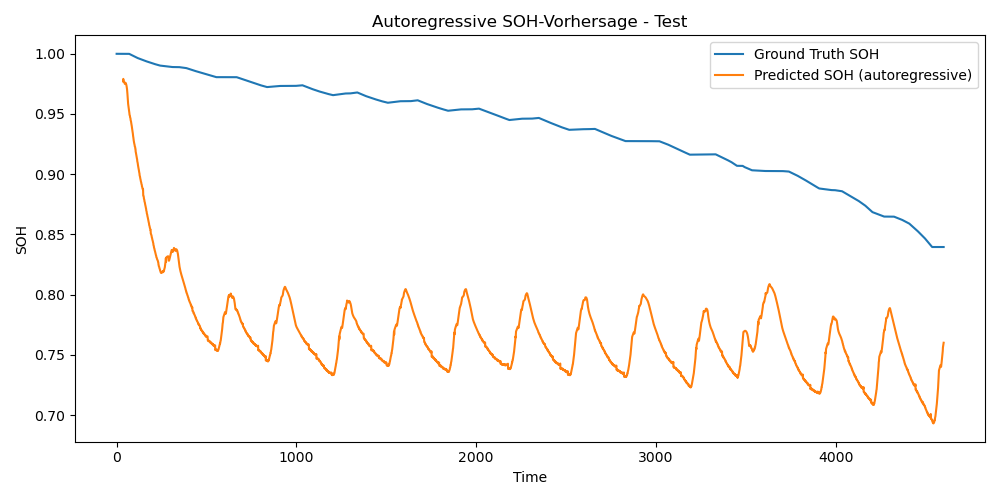

In [28]:
true_target = test_scaled['SOH_ZHU'].values  # "echter" SOH (unskalierter, da 0..1)
timeidx  = test_scaled['Testtime[h]'].values

# scaler_soh = RobustScaler()
# train_scaled['SOH_ZHU'] = scaler_soh.fit_transform(train_df[['SOH_ZHU']])

# preds_unscaled = scaler_soh.inverse_transform(preds_target.reshape(-1, 1)).flatten()
# true_unscaled = scaler_soh.inverse_transform(true_target.reshape(-1, 1)).flatten()

plt.figure(figsize=(10,5))
plt.plot(timeidx, true_target, label="Ground Truth SOH")
plt.plot(timeidx, preds_target, label="Predicted SOH (autoregressive)")
plt.title(f"Autoregressive SOH-Vorhersage - Test")
plt.xlabel("Time")
plt.ylabel("SOH")
plt.legend()
plt.tight_layout()